# NLP 2024
# Lab 2: Word Embeddings

Throughout the course we have discussed different ways to represent a word. The latest one (and the most successful in terms of results) is using word embeddings: we represent each word as a vector consisting of numbers. The vector encodes the meaning of the word. These numbers (or weights) for each word are learned using various machine learning models. In this lab, we explore how to create such vectors given a corpus (note that in the real world, you can also load the trained word vectors, and you will almost never have to train them from scratch), which properties they have and what kind of tasks we can solve with them.

By the end of this lab you should be able to:
- Implement and/or use built-in functions to preprocess your data (once again)
- Execute `word2vec` based on a corpus
- Inspect and test word embeddings properties
- Use word embeddings to get sentence representations (aka sentence embeddings)
- Use sentence embeddings to solve more complicated tasks like information retrieval
- Design evaluation frameworks for specific NLP tasks and assess their difficulty

### Score breakdown

Exercise | Points
--- | ---
[Exercise 1](#e1) | 3
[Exercise 2](#e2) | 3
[Exercise 3](#e3) | 3
[Exercise 4](#e4) | 5
[Exercise 5](#e5) | 10
[Exercise 6](#e6) | 6
[Exercise 7](#e7) | 5
[Exercise 8](#e8) | 5
[Exercise 9](#e9) | 5
[Exercise 10](#e10) | 5
[Exercise 11](#e11) | 5
[Exercise 12](#e12) | 15
Total | 70

This score will be scaled down to 1 and that will be your final lab score.

### Instructions for delivery (Deadline: 17/May late night, wildcards possible)

+ Make sure that you include a proper amount/mix of comments, results and code.
+ In the end, make sure that all cells are executed properly and everything you need to show is in your (execucted) notebook.
+ You are asked to deliver only your executed notebook file, .ipnyb and nothing else. Enjoy!
+ Honor code applies to these tasks. Only individual work should be submitted.
+ While you may talk with others about this lab, we ask that you write your solutions individually. If you do discuss specific tasks with others please include their names below.
+ It is mandatory to list and disclose any website (or other resource) you used (e.g. stackoverflow) as well as any genAI tools (e.g. chatGPT) used.

Collaborators: list collaborators here

**I talked with Jerry about...**

Use of genAI tools (e.g. chatGPT), websites (e.g. stackoverflow): list websites where you found code (or other info) as well as include information on how you used genAI tools (e.g. prompts):

I asked chatGPT about...

## 0. Setup

As in the last lab, we will be using huggingface datasets library ([https://huggingface.co/datasets](https://huggingface.co/datasets)). You can find the detailed documentation and tutorials here: [https://huggingface.co/docs/datasets/en/index](https://huggingface.co/docs/datasets/en/index)

If you don't have it installed you can run the code below:

In [2]:
! pip install -U datasets~=2.18.0

As usual, we start by importing some essential Python libraries and we will be using. Apart from `gensim` (which is going to be used for word2vec), we have already seen the others.

In [3]:
import re  # for regular expressions
import random
import math

import numpy as np
import matplotlib.pyplot as plt
import datasets
import gensim
import nltk
import tqdm

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/wiksrivastava/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Load and Preprocess Data

*Sentence compression* involves rephrasing sentences to make them shorter while still retaining the original meaning. A reliable compression system would be valuable for mobile devices and could also serve as a component in an extractive summarization system.

The dataset we are going to use can be found on [Huggingface](https://huggingface.co/datasets/embedding-data/sentence-compression). It concerns a set of 180,000 pairs of sentences, aka it is a parallel corpus of sentences and their equivalent compressions. It has been collected by harvesting news articles from the Internet where the headline appears to be similar to the first sentence and that property is used to find an "extractive" compression of the sentence.

For example, for the sentence

`"Regulators Friday shut down a small Florida bank, bringing to 119 the number of US bank failures this year amid mounting loan defaults"`

the compressed equivalent (based on the dataset) is:

`"Regulators shut down small Florida bank"`.


For more information you can read the original paper (from Google) [here](https://aclanthology.org/D13-1155.pdf). We strongly recommend going over the paper to gain further insights. Notice that the paper is from 2013, therefore word embeddings have not been widely introduced yet in NLP tasks, meaning that the methods applied were based on the traditional NLP pipeline (feature extraction + ML).

### 1.1 Loading the Dataset

The dataset will be loaded as a Pandas DataFrame. This may take a few minutes because of the large size of the data.

Make sure to inspect the dataset and make sure it is imported properly.

In [4]:
ds = datasets.load_dataset('embedding-data/sentence-compression')
print(ds)

DatasetDict({
    train: Dataset({
        features: ['set'],
        num_rows: 180000
    })
})


In [5]:
for i in range(10):
    print(ds['train'][i])

{'set': ["The USHL completed an expansion draft on Monday as 10 players who were on the rosters of USHL teams during the 2009-10 season were selected by the League's two newest entries, the Muskegon Lumberjacks and Dubuque Fighting Saints.", 'USHL completes expansion draft']}
{'set': ['Major League Baseball Commissioner Bud Selig will be speaking at St. Norbert College next month.', 'Bud Selig to speak at St. Norbert College']}
{'set': ["It's fresh cherry time in Michigan and the best time to enjoy this delicious and nutritious fruit.", "It's cherry time"]}
{'set': ['An Evesham man is facing charges in Pennsylvania after he allegedly dragged his girlfriend from the side of his pickup truck on the campus of Kutztown University in the early morning hours of Dec. 5, police said.', 'Evesham man faces charges for Pa.']}
{'set': ["NRT LLC, one of the nation's largest residential real estate brokerage companies, announced several executive appointments within its Coldwell Banker Residential B

The dataset comes with only the `train` split so we will have to split it ourselves.

In [6]:
split_ds = ds['train'].train_test_split(test_size=0.2)
print(split_ds)

DatasetDict({
    train: Dataset({
        features: ['set'],
        num_rows: 144000
    })
    test: Dataset({
        features: ['set'],
        num_rows: 36000
    })
})


### 1.2 Preprocessing the dataset
In this section we will prepare the dataset, aka clean the sentences and tokenizem.

First, let's write the function to clean the text. It can be similar to the one from the previous lab (Lab1) but make sure that it makes sense for this dataset and task.

More specifically, think about lower-casing, punctuation, stop-words and lemmatization/stemming and the impact it might have on the dataset. Also reflect on the fact that with word2vec we want to uncover semantic relationships between words, whereas with bag-of-words we were trying to capture different morphological variations.

<a name='e1'></a>
### Exercise 1 (points 3)
Fill in the following function ot clean the dataset.

In [7]:
def clean(text):
    """
    Cleans the given text
    Args:
        text: a str with the text to clean

    Returns: a str with the cleaned text

    """

    # Empty text
    if type(text) not in (str, np.str_) or text == '':
        print('empty text', type(text), type(text) not in (str, np.str_), text)
        return ''

    # 'text' from the example can be of type numpy.str_, let's convert it to a python str
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub("\'s", " ",
                  text)  # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)

    #you might need more
    #add them here

    ### YOUR CODE HERE

    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)    
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub("\'ll", " will ", text)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'m", " am ", text)
    text = re.sub("n\'t", " not ", text)

    #! learning from my mistake of pre-processing too much in the previous lab assignment.
    #! im trying to be more careful here, and do things contextually


    ### YOUR CODE ENDS HERE

    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)

    text = text.strip()

    # Update the example with the cleaned text
    return text

The following function will apply the function (sic) you just wrote to the whole dataset. More specifically, it takes the first entry (`sentence`) from the set of uncompressed/compressed pairs, applies the `clean` function and saves the processed sentence in the field `clean_sentence`. The same is dome for the compressed version of the sentence (saved as `clean_compressed`).

In [8]:
def clean_dataset(example):
    """
    Cleans the sentence and compressed sentence in the example from the Dataset
    Args:
        example: an example from the Dataset

    Returns: updated example with 'clean_sentence' and 'clean_compressed' cleaned

    """
    sentence, compressed = example['set']
    clean_sentence = clean(sentence)
    clean_compressed = clean(compressed)
    example['clean_sentence'] = clean_sentence
    example['clean_compressed'] = clean_compressed
    return example

Below we apply the function to the whole dataset (using `map`) and we can also inspect the result.

In [9]:
split_ds = split_ds.map(clean_dataset)
print(split_ds)

Map:   0%|          | 0/144000 [00:00<?, ? examples/s]

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['set', 'clean_sentence', 'clean_compressed'],
        num_rows: 144000
    })
    test: Dataset({
        features: ['set', 'clean_sentence', 'clean_compressed'],
        num_rows: 36000
    })
})


Let's examine some examples from the dataset and make sure that we got the results we wanted. At this step, it might be necessary to revisit some pre-processing steps if you are not happy with the results.

In [10]:
for i in range(10):
    print(split_ds['train'][i])

{'set': ['The Crunch returned home Sunday after three playoff games in Canada.', 'Syracuse Crunch return home'], 'clean_sentence': 'the crunch returned home sunday after three playoff games in canada', 'clean_compressed': 'syracuse crunch return home'}
{'set': ['National news Warning after betting shop murder A 55-year-old man who was murdered at a betting shop has been named by police as they warned the public not to approach a suspect they are hunting.', 'National news Warning after betting shop murder'], 'clean_sentence': 'national news warning after betting shop murder a 55 year old man who was murdered at a betting shop has been named by police as they warned the public not to approach a suspect they are hunting', 'clean_compressed': 'national news warning after betting shop murder'}
{'set': ['The Redskins met with Rogers Friday, though league sources say Rogers had drawn interest from approximately 10 teams and wanted to take his time.', 'Redskins meet with Rogers'], 'clean_sente

<a name='e2'></a>
### Exercise 2 (points 3)

As always, we will need to tokenize the dataset in order to train our own `word2Vec` model in the next section. We will use the [Natural Language Toolkit (NLTK) library]([https://www.nltk.org/]) (https://www.nltk.org/).

Complete the following function to split the text into tokens using the `word_tokenize()` function. Check the [documentation](https://www.nltk.org/api/nltk.tokenize.word_tokenize.html?highlight=word_tokenize) first.

Note that there are different tokenizers e.g. `RegexpTokenizer` where you can enter your own regexp, `WhitespaceTokenizer` (similar to Python's string.split()) and `BlanklineTokenizer`.

In [11]:
# if you want you can remove the stopwords
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

def tokenize(text):
    """
    Tokenizes the `text` parameter using nltk library
    Args:
        text: a string representing a sentence to be tokenized

    Returns: a list of tokens (strings)

    """

    ### YOUR CODE HERE
    tokens = nltk.tokenize.word_tokenize(text, language='english', preserve_line=False)
    tokens = [word for word in tokens if word not in stop_words]


    ### YOUR CODE ENDS HERE
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wiksrivastava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Next, the function will be applied to the whole dataset (as we did with the pre-processing) and `sentence_tokens` field will be created to store the result.

In [12]:
def tokenize_dataset(example):
    """
    Tokenizes 'clean_sentence' columns in the example from the Dataset
    Args:
        example: an example from the Dataset

    Returns: updated example with 'sentence_tokens' columns

    """
    cleaned_sentence = example['clean_sentence']
    tokens = tokenize(cleaned_sentence)
    example['sentence_tokens'] = tokens
    return example

In [13]:
split_ds = split_ds.map(tokenize_dataset)

Map:   0%|          | 0/144000 [00:00<?, ? examples/s]

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

In [14]:
for i in range(10):
    print(split_ds['train'][i])

{'set': ['The Crunch returned home Sunday after three playoff games in Canada.', 'Syracuse Crunch return home'], 'clean_sentence': 'the crunch returned home sunday after three playoff games in canada', 'clean_compressed': 'syracuse crunch return home', 'sentence_tokens': ['crunch', 'returned', 'home', 'sunday', 'three', 'playoff', 'games', 'canada']}
{'set': ['National news Warning after betting shop murder A 55-year-old man who was murdered at a betting shop has been named by police as they warned the public not to approach a suspect they are hunting.', 'National news Warning after betting shop murder'], 'clean_sentence': 'national news warning after betting shop murder a 55 year old man who was murdered at a betting shop has been named by police as they warned the public not to approach a suspect they are hunting', 'clean_compressed': 'national news warning after betting shop murder', 'sentence_tokens': ['national', 'news', 'warning', 'betting', 'shop', 'murder', '55', 'year', 'old',

Since we will need the tokenized sentences, we can use the following statement to extract them from the `train` split of our dataset.

In [15]:
tokenized_sentences = split_ds['train']['sentence_tokens']
print(len(tokenized_sentences))
print(tokenized_sentences[:10])

144000
[['crunch', 'returned', 'home', 'sunday', 'three', 'playoff', 'games', 'canada'], ['national', 'news', 'warning', 'betting', 'shop', 'murder', '55', 'year', 'old', 'man', 'murdered', 'betting', 'shop', 'named', 'police', 'warned', 'public', 'approach', 'suspect', 'hunting'], ['redskins', 'met', 'rogers', 'friday', 'though', 'league', 'sources', 'say', 'rogers', 'drawn', 'interest', 'approximately', '10', 'teams', 'wanted', 'take', 'time'], ['ballistic', 'publishing', 'announces', 'expos', '6', 'latest', 'book', 'groundbreaking', 'series', 'celebrating', 'world', 'finest', 'digital', 'art', 'expos', 'flagship', 'title', 'ballistic', 'publishing', 'become', 'institution', 'digital', 'art', 'world'], ['ashley', 'greene', 'sunbathes', 'topless', 'shoots', 'scenes', 'new', 'movie'], ['clarke', 'backs', 'drs', 'technology', 'updated', '05', '43', 'saturday', 'february', '16', '2013', 'australia', 'captain', 'michael', 'clarke', 'says', 'fan', 'cricket', 'decision', 'review', 'system',

Notice the difference in the types of the different structures we use. Run the following cell to check the types. Do they make sense to you?

In [16]:
#type of original dataset
print(type(split_ds))
print("--")
#type of original sentence
print(split_ds['train'][1])
print(type(split_ds['train'][1]))
print("--")
#type of pre-proceesed sentence
print(split_ds['train']['clean_sentence'][1])
print(type(split_ds['train']['clean_sentence'][1]))
print("--")
#type of tokenized sentence
print(split_ds['train']['sentence_tokens'][1])
print(type(split_ds['train']['sentence_tokens'][1]))
print("--")

<class 'datasets.dataset_dict.DatasetDict'>
--
{'set': ['National news Warning after betting shop murder A 55-year-old man who was murdered at a betting shop has been named by police as they warned the public not to approach a suspect they are hunting.', 'National news Warning after betting shop murder'], 'clean_sentence': 'national news warning after betting shop murder a 55 year old man who was murdered at a betting shop has been named by police as they warned the public not to approach a suspect they are hunting', 'clean_compressed': 'national news warning after betting shop murder', 'sentence_tokens': ['national', 'news', 'warning', 'betting', 'shop', 'murder', '55', 'year', 'old', 'man', 'murdered', 'betting', 'shop', 'named', 'police', 'warned', 'public', 'approach', 'suspect', 'hunting']}
<class 'dict'>
--
national news warning after betting shop murder a 55 year old man who was murdered at a betting shop has been named by police as they warned the public not to approach a suspe

## 2. Word2Vec word embeddings

Before proceeding below make sure that you understand the way Word2Vec words. Refer to the lecture slides and/or the textbooks. Here we provide a (very) rough introduction that is lacking many details we discussed in class.

Word2vec operates on the principle that words appearing in similar contexts tend to have similar meanings. There are two main algoriths with diffferent variations. in Skip-gram the model precits the context words given the target word, whereas in CBOW the model predicts the target word given its context words (words surrounding it). During training (which can take a lot of time in case of big corpora), word2Vec updates the vector representations of words to maximize the probability of correctly predicting the target or context words. If we use a neural network, training is done with gradient descent.

We need to decide on different parameters that will influence the behavior and performance of word2Vec models. These include the dimensionality of the word vectors which determines the size of the vector space in which words are embedded, and the window (context) size, which defines the number of context words considered in each training instance. Additionally, the choice of training algorithm (CBOW or Skip-gram), learning rate, number of training epochs need to be tuned.

Nough said, it's time to train our own Word2Vec embeddings. We will use the powerful [Gensim library](https://radimrehurek.com/gensim/models/word2vec.html). Make sure to read the documentation to decrypt the parameters we need to tune (embedding vector size, context window, type of algorithm etc.). The training might take some time, depending on the parameters you use.



In [17]:
from gensim.models import Word2Vec

embedding_size = 100
w2v_model = Word2Vec(tokenized_sentences, vector_size=embedding_size, min_count=5, window=5, sg=1, hs=0, seed=1,
                     workers=4)

In [18]:
w2v_model.train(tokenized_sentences, total_examples=len(tokenized_sentences), epochs=10)

(22221128, 23639780)

The Word2Vec model has `wv` attribute. We can use it to retrieve the whole vocabulary (aka for how many words we learned embeddings for).

In [19]:
vocab = list(w2v_model.wv.key_to_index)
print(len(vocab))

27356


Here you can see the word cloud created from the vocabulary.

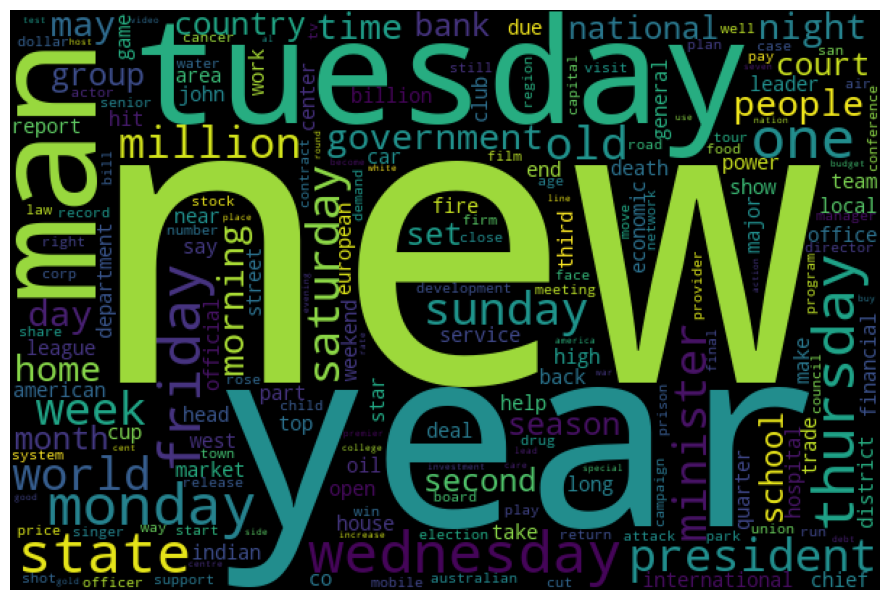

In [20]:
# visualizing our vocab with a word cloud.
from wordcloud import WordCloud

# Generate a word cloud image for words
combined_vocab = ' '.join(vocab)
wordcloud = WordCloud(width=600, height=400).generate(combined_vocab)
plt.figure(figsize=(9, 9))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout()
plt.show()

Let's explore a bit further the embeddings. In the following cells, the embedding of a single word is returned. Double-check the dimensions (as sanity check). This is like inspecting the `W` matrix (weights) that we discussed in the lecture.

In [21]:
# vector of a particular model. note that it is 100 dimensional as specified.
#! it is odd that stop words were used in the example which were already processed out of the dataset.
#! i changed the words to make the code not crash
w2v_model.wv['man']

array([-3.2109153e-01,  7.9097256e-02, -2.2244747e-01,  8.1682396e-01,
        6.5291263e-02, -8.8252261e-02, -6.2767774e-01,  8.9649767e-01,
       -3.0988351e-01,  7.9003405e-03, -1.1869730e-01, -5.4946828e-01,
        6.4021939e-01,  9.3360789e-02,  4.9040812e-01, -1.6661541e-01,
        3.1633809e-01, -4.7274646e-01,  3.5032690e-02, -5.8017117e-01,
       -1.3375444e-04,  1.3076140e-02, -2.1469979e-01, -4.4820264e-01,
        5.9443069e-01, -1.7656782e-01, -3.3260632e-01,  2.9363573e-01,
       -5.2024776e-01, -2.1126942e-01,  6.4184427e-01,  4.7696090e-01,
       -1.8913619e-01,  5.2179790e-01, -1.8219064e-01, -8.4928528e-04,
       -1.7921700e-01, -2.4324775e-01,  2.7247597e-02, -4.6600074e-02,
       -5.2379100e-03,  4.0212476e-01,  3.5382099e-02,  1.1823576e-01,
       -5.1156502e-02,  4.9487710e-02,  1.0253812e-01,  2.5868151e-01,
       -9.1131561e-02,  6.2518471e-01,  8.8347271e-02, -1.0078354e-01,
       -5.9683436e-01,  5.0160632e-02, -3.8978288e-01, -2.8461471e-01,
      

In [22]:
# can also do like this.
w2v_model.wv['apple']

array([-1.17260829e-01,  2.36474097e-01,  5.48600674e-01,  1.74893271e-02,
        7.84163833e-01, -9.77325797e-01, -4.80283573e-02,  3.06055278e-01,
        2.63691604e-01,  4.19953018e-02, -8.81884471e-02, -4.50355411e-01,
       -8.12549889e-02,  1.20329782e-01,  4.94513959e-01, -3.11366946e-01,
       -5.43277785e-02, -3.19497973e-01,  4.65977460e-01, -6.14394486e-01,
        7.26589262e-01, -3.49573910e-01,  1.62126496e-01, -4.69119430e-01,
        1.53919443e-01,  1.49293346e-02, -1.08979680e-01,  2.35346273e-01,
       -7.83600867e-01,  1.31324157e-01, -1.51488394e-01, -2.37726662e-02,
       -4.42356378e-01, -9.63483602e-02,  1.29958719e-01,  8.36735487e-01,
        5.81039011e-01,  4.68912244e-01, -6.00285649e-01,  1.51489722e-02,
        8.95880044e-01, -9.76169705e-02, -2.96884865e-01, -2.98301071e-01,
        3.82969320e-01, -8.68349895e-02,  5.18304944e-01,  5.50622642e-01,
        7.19550490e-01, -1.81367695e-01,  1.64223075e-01, -8.02305294e-04,
        2.68290229e-02, -

`word2vec` offers different functions to easily run very common tasks. For example, there are different functions to find the most similar words.

Check the documentation on how [`most_similar`](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html) and [`similar_by_word`](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.similar_by_word.html) can be used.

In [23]:
# most similar words to a given word
print(w2v_model.wv.most_similar('man', topn=10))

# also u can use
print(w2v_model.wv.similar_by_word('miss', topn=5))

[('woman', 0.8934177756309509), ('toddler', 0.7062221169471741), ('samurai', 0.6951417922973633), ('wallaceburg', 0.6939680576324463), ('fatally', 0.6888188123703003), ('stepson', 0.6755571961402893), ('chiropractor', 0.672778844833374), ('motorcyclist', 0.6677003502845764), ('teenager', 0.6670076251029968), ('assailant', 0.6554168462753296)]
[('sprained', 0.6361438035964966), ('achilles', 0.6345187425613403), ('mcl', 0.634308934211731), ('marcum', 0.6292147040367126), ('rupturing', 0.6224812269210815)]


In [24]:
print(w2v_model.wv.most_similar('cry', topn=10))

[('obnoxious', 0.6628726124763489), ('temptation', 0.6539660096168518), ('tired', 0.6254674196243286), ('fuzzy', 0.6252548098564148), ('embarrassed', 0.6224068403244019), ('impression', 0.6187126636505127), ('weird', 0.6158967018127441), ('boobs', 0.6130183935165405), ('tomboy', 0.6120103001594543), ('obviously', 0.6064270734786987)]


In [25]:
print(w2v_model.wv.similar_by_word('kill', topn=5))

[('plotted', 0.6771125197410583), ('assassinate', 0.6169957518577576), ('granddad', 0.6039846539497375), ('stoning', 0.6004299521446228), ('terroristic', 0.5986157655715942)]


<a name='e3'></a>
### Exercise 3 (points 3)

While there is already a similarity metric in the `word2Vec` class, we will write our own implementation of the cosine similarity. Complete the following funciton that given any two vectors will compute the cosine similarity. If you don't remember the formula for the cosine similarity, revisit the course material. Notice that the function receives numpy arrays and recall that you can express cosine similarity as a dot product. Use numpy functions to write an efficient implementation.

In [26]:
def cosine_similarity(vector1, vector2):
    """
    Computes the cosine similarity between two vectors
    Args:
        vector1: numpy array of the first vector
        vector2: numpy array of the second vector

    Returns: cosine similarity

    """
    ### YOUR CODE HERE
    numeratorDotProduct = np.dot(vector1, vector2)
    
    magnitudeVector1 = np.linalg.norm(vector1)
    magnitudeVector2 = np.linalg.norm(vector2)
    
    if magnitudeVector1 == 0 or magnitudeVector2 == 0:
        return 0.0  
    
    cosineSimilarity = numeratorDotProduct / (magnitudeVector1 * magnitudeVector2)
    
    return cosineSimilarity
    ### YOUR CODE ENDS HERE

In [27]:
cosine_similarity(np.array([0, 1, 2]), np.array([0, 1, 2]))

0.9999999999999998

We can now compare our implementation with the one in the Word2Vec model and confirm what we already expected.

In [28]:
# simalarity between two words
word1 = 'alive'
word2 = 'biology'
print(w2v_model.wv.similarity(word1, word2))
print(cosine_similarity(w2v_model.wv[word1], w2v_model.wv[word2]))

0.16621631
0.16621631


In [29]:
# simalarity between two words. similar words
word1 = 'alive'
word2 = 'life'
print(w2v_model.wv.similarity(word1, word2))
print(cosine_similarity(w2v_model.wv[word1], w2v_model.wv[word2]))

0.35589528
0.35589528


In [30]:
# simalarity between two words. dissimilar words
word1 = 'alive'
word2 = 'dead'
print(w2v_model.wv.similarity(word1, word2))
print(cosine_similarity(w2v_model.wv[word1], w2v_model.wv[word2]))

0.49597394
0.49597394


In [31]:
# simalarity between two words. unrelated words
word1 = 'alive'
word2 = 'horse'
print(w2v_model.wv.similarity(word1, word2))
print(cosine_similarity(w2v_model.wv[word1], w2v_model.wv[word2]))


0.32125852
0.32125852


In [32]:
# simalarity between two SAME words
w2v_model.wv.similarity('equal', 'equal')
word1 = 'equal'
word2 = 'equal'
print(w2v_model.wv.similarity(word1, word2))
print(cosine_similarity(w2v_model.wv[word1], w2v_model.wv[word2]))


1.0
1.0


The next function contains the code to plot a similarity matrix between multiple words (e.g. if we want to compare 10 words and their pair-wise similarities). It requires a matrix with similarities (as input) and labels (aka the words) to display in the final figure.

In [33]:
def plot_similarity_matrix(matrix, labels):
    """
    Displays a plot of the `matrix` of size (N x N) with the labels specified as a list of size N
    Args:
        matrix: a square-sized (N x N) numpy array
        labels: a list of strings of hte size N
    """

    fig, ax = plt.subplots()
    im = ax.imshow(matrix)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(labels)), labels=labels)
    ax.set_yticks(np.arange(len(labels)), labels=labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{matrix[i, j]:.2f}',
                           ha="center", va="center", color="w")

    # ax.set_title("Give a title if you want")
    fig.tight_layout()
    plt.show()

<a name='e4'></a>
### Exercise 4 (points 5)

In the following, we will explore some properties of word embeddings through some examples. We will use 6 example words for this purpose but feel free to explore some of your own (also for Exercise 5).

First, fill in the next cell to create a similarity matrix between a list of words. Then, call the function given above that plots the similarity matrix, along with the word labels.

In the cell, below comment on the results. Based on the word2vec parameters you explored, do they make sense?

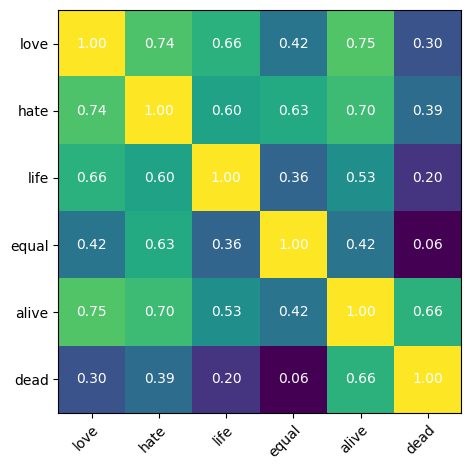

In [34]:
list_of_words = ['love', 'hate', 'life', 'equal', 'alive', 'dead']

similarity_matrix = np.zeros((len(list_of_words), len(list_of_words)), dtype=float)

### YOUR CODE HERE

w2v_model = Word2Vec(
    tokenized_sentences,
    vector_size=100,  # parameter means each word is represented by a n-dimensional vector. this is a typical size that captures a good amount of semantic information
    window=5,         # parameter indicates that the model considers a context window of 5 words around each target word
    min_count=1,      # minimum word frequency
    negative=5,       # parameter specifies the number of negative samples, which helps improve the model's robustness by distinguishing between correct and incorrect context words
)

for i, word1 in enumerate(list_of_words):
    for j, word2 in enumerate(list_of_words):
        similarity = w2v_model.wv.similarity(word1, word2)
        similarity_matrix[i, j] = similarity

### YOUR CODE ENDS HERE

plot_similarity_matrix(similarity_matrix, list_of_words)


<a name='e5'></a>
### Exercise 5 (points 10)

For this exercise, experiment with different words and their similarities plotted. Also, take into account the different parameters of word2vec and more specifically the window size (context) and the role it plays in the types of embeddings we can learn.

What happens if I pick a small context window?
What happens if I pick a large context window?

Are there noticeable patterns? Are they expected? Try to find examples that word embeddings make sense (based on your hypothesis) and not.

Comment on your findings below.

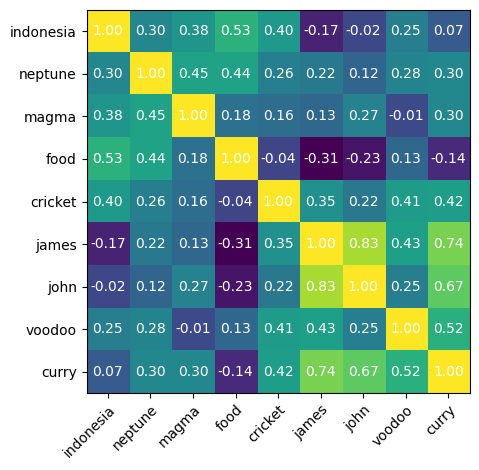

In [35]:
list_of_words = ['indonesia','neptune','magma','food','cricket','james','john','voodoo','curry']
similarity_matrix = np.zeros((len(list_of_words), len(list_of_words)), dtype=float)

w2v_model = Word2Vec(tokenized_sentences,vector_size=100,window=5,min_count=1,negative=3)

for i, word1 in enumerate(list_of_words):
    for j, word2 in enumerate(list_of_words):
        similarity = w2v_model.wv.similarity(word1, word2)
        similarity_matrix[i, j] = similarity

plot_similarity_matrix(similarity_matrix, list_of_words)

// **your comments**

**QUESTION 4 and 5**

1. **Word Pair Similarities**:
   - Words like 'love' and 'hate'  show higher similarity as they often co-occur in the same context in our corpus. While this explanation makes sense, I was expecting opposing values. With this experimentation I better understand how this works, and what these values signify with more clarity.

   - Conversely, pairs like 'life' and 'dead' or 'equal' and 'dead' show much lower similarity. This was intersting as this hints how the words may have been used in this corpus. Similar meaning words could be used in different contexts and their similarity rates could be very different to that of their real meanings. Such values of word similarity are interesting. To explore and expand my understanding, I will play around with words for question 5.

2. **Parameter Impact**:
   - The `vector_size' determines the dimension of representation for each word. A vector size = 10 would be computed faster than 1000. The results for different vector sizes demonstrate how the size of the data impacts similarity. For a 1000 dimension matrix, the values seem to have started converging, while less dimensions had slighlty more divergant data. This was interesting to explore.

   - The `window` parameter indicates that the model considers a context window of x words around each target word, providing a balanced context for training. A smaller window showcased lower dissimilarity than than a larger window. However, the spread of values was much smaller for a small window. This observation was done for window sizes of 2, 5, 10 and 20. The observations seemed consistent with the above mentioned point.
   - With a small context window, the model focuses on the immediate context of a word, capturing specific relationships. This also makes them more sensitive to specific word usage and local dependencies. However, this could result in missing the broader relationships of a document or data because the focus is too narrow.
   - With a large context window, the model focuses on broader relationships between words. This helps the embeddings represent topics and themes, as the context includes a larger set of words.

   - The 'min_count' again amplified the values. I experimented with min count of 1, 2, 5, 10 and 20. With the increase in frequency, the spread in similarity increased. Dissimilar words were regarded as even more dissimilar and vice-versa. I beleive this happened as multiple instances of said 'dissimilarity' or 'similarity' influenced such results. I also wished to test for min count = 100, but I got an error as some words did not appear as many times. For this to make a lot more sense for a bigger list of words, it would be smart to remove stop words as we did, as they tend to appear the most times, without adidng much meaning to the corpus. Often very rare words also don not contribute to the corpus in a wider sense. It is crucial to estimate the right values to work with as analysis can vary because of that.

   - The `negative=5` parameter specifies the number of negative samples, which helps improve the model's robustness by distinguishing between correct and incorrect context words.
   
The parameters and their impact seem to make sense for the data that was observed from the corpus. There are certainly more factors such as learning rate and alpha but I felt that there factors were more machine learning oriented as compared to the ones I explored. I stuck to the ones that were directly relevant to NLP and language/sentence structure to enhance my understanding of this topic.


words: list_of_words = ['indonesia','neptune','magma','food','cricket','james','john','voodoo','curry']

1. **Word Pair Similarities**:
   - The words seems to have interesting similarity-dissimilarity values. While my lsit of words are rather dissimilar, I felt that certain words would be more similar than others. The words 'food' and 'curry' are related and I believed that the corpus would showcase them as similar but they seem to be some of the most dissimilar words here. In contrast, words like 'james' and 'curry' are some of the most similar words, which was a shock to me. I also felt that 'indonesia' and 'curry' might land better similarity but they were again almost opposites. The only hypothesis of mine that was entirely accurate remains to be the similarity between 'james' and 'john'. 
   
   - There were a lot of pairs whose values surprised me a lot but since they dont happen to be directly related/unrelated, I cant say I had concrete hypothesis for them.
   Throughout, I experimented with different and more words. I didn't save the data for all, but this set of words seems to be the most interesting of them all. 

2. **Parameter Impact**:
   - I experimented with the same parameters as Question 4. I was able to experiment with more values and yield results, most of which were consistent from my observations from question 1. For a few parameters values, the output seemed to follow maybe a parabola pattern, with minima/maxima values. This could be very conrpus dependent, as the positioning of words is essential in determining the similarity between words. A change in sample size for dataset would impact how a word is percieved. 

   - This was however, only experienced with changed in the window parameter. Otherwise, they had a predictable impact. 
   
   - Also, since I experimented with more values, it was a little more difficult to analyse. It might be advisable to work with smaller sets. That would help with more preciese analysis and faster processing times. With as many randomised words, it was also difficult to play with the 'min count' parameter. If we have highly specific data set, it might be easier to know what words make sense in a corpus and what dont. It would also be slighlty easier to predict the frequency of a word to fix the parameters accordingly. 
   
   
The parameters and their impact seem to make sense for the data that was observed from the corpus. There are certainly more factors such as learning rate and alpha but I felt that there factors were more machine learning oriented as compared to the ones I explored. I stuck to the ones that were directly relevant to NLP and language/sentence structure to enhance my understanding of this topic.


## 3. Pre-trained embeddings

In this short section you will load the pre-trained embeddings of your choice. Gensim library maintains a storage containing some pre-trained models. You can read more about it [here](https://github.com/piskvorky/gensim-data) ([https://github.com/piskvorky/gensim-data](https://github.com/piskvorky/gensim-data)). Be sure to read the README of this repository.

Let's first load the info of what models are available.

In [36]:
import json
import gensim.downloader as api

info = api.info()  # show info about available models/datasets
print(json.dumps(info['models'], indent=2))

{
  "fasttext-wiki-news-subwords-300": {
    "num_records": 999999,
    "file_size": 1005007116,
    "base_dataset": "Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens)",
    "reader_code": "https://github.com/RaRe-Technologies/gensim-data/releases/download/fasttext-wiki-news-subwords-300/__init__.py",
    "license": "https://creativecommons.org/licenses/by-sa/3.0/",
    "parameters": {
      "dimension": 300
    },
    "description": "1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).",
    "read_more": [
      "https://fasttext.cc/docs/en/english-vectors.html",
      "https://arxiv.org/abs/1712.09405",
      "https://arxiv.org/abs/1607.01759"
    ],
    "checksum": "de2bb3a20c46ce65c9c131e1ad9a77af",
    "file_name": "fasttext-wiki-news-subwords-300.gz",
    "parts": 1
  },
  "conceptnet-numberbatch-17-06-300": {
    "num_records": 1917247,
    "file_size": 1225497562,
    "base_dataset": "ConceptN

<a name='e6'></a>
### Exercise 6 (points 6)

Load the pre-trained word embeddings model of your choice (like we did in the lecture: e.g. try different pre-trained corpora and different types of embeddings (like GloVe or FastText)). You can use the gensim implementation and functionality to download and load several types of embeddings, but you are not limited to it.

Next, perform the analysis of the similarities between words as you did in Exercise 5. Compare your trained word2vec with the pretrained model you downloaded. Try to explain the numerical differences based on what you know on how these models were trained.

Note: Pre-trained embeddings might be difficult to load and use (memory requirements) so you might have to work locally there. You don't need to submit (really, don't!) the pre-trained word embeddings you used but make sure to include a link in your delivered notebook.

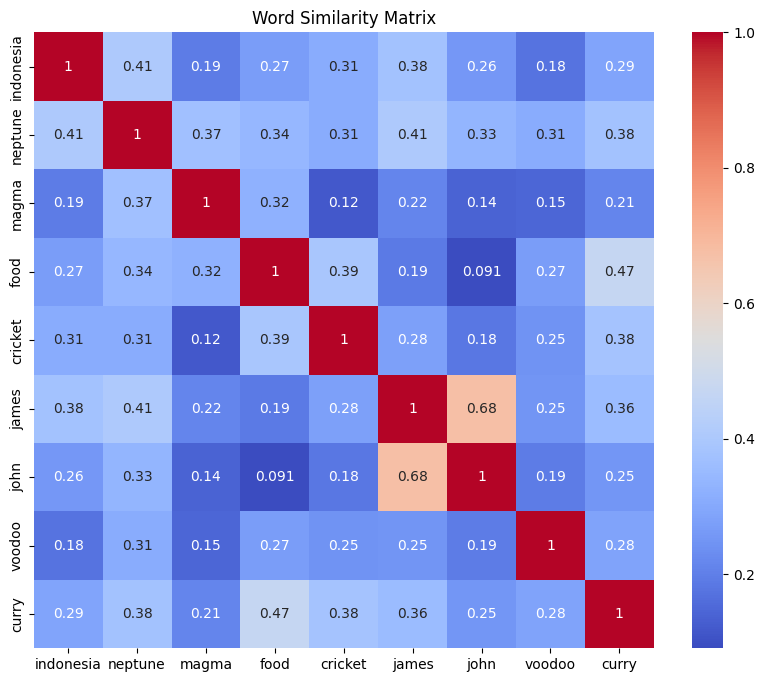

In [37]:
import numpy as np
import gensim.downloader as api
import matplotlib.pyplot as plt
import seaborn as sns

#! i used chatGPT for some guidance in this step. 

model = api.load('fasttext-wiki-news-subwords-300')

list_of_words = ['indonesia', 'neptune', 'magma', 'food', 'cricket', 'james', 'john', 'voodoo', 'curry']

words_in_vocab = [word for word in list_of_words if word in model.key_to_index]
missing_words = set(list_of_words) - set(words_in_vocab)
if missing_words:
    print(f"Words not found in the pre-trained model's vocabulary: {missing_words}")

similarity_matrix = np.zeros((len(list_of_words), len(list_of_words)), dtype=float)

for i, word1 in enumerate(list_of_words):
    for j, word2 in enumerate(list_of_words):
        similarity = model.similarity(word1, word2)
        similarity_matrix[i, j] = similarity

def plot_similarity_matrix(matrix, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, annot=True, cmap='coolwarm')
    plt.title('Word Similarity Matrix')
    plt.show()

plot_similarity_matrix(similarity_matrix, list_of_words)


// your comments

The results of this corpora for the previous list of words is surprisingly very different. The values align much more closely with my initial hypotheses. Words that I excpected to be similar are more similar for this calculation. I feel some inner joy knowing that 'curry' is most similar to 'food' than some 'james'. The plot also consistently respresents james and john to be similar in both the corpora. This might be a sign that it may have detected that it is a name (used in a specific context and setting). These similarity values are much closer to how I believe they would be graded in a real life scenario. So this makes me wonder if the window size is big or just if the corpora is very representive. The most similar and dissimilar words seem to makes sense. There is also the absence of negative values which is consistent, as there are no opposites used in the list of words. The presence of negative words in the previous plot made little sense to me.  

This is very interesting to work with. I will be testing some other words to test if other words and hypothesis align.

If you encounter problems with not enough RAM you can modify and run the following cell to unload the pretrained model from memory. Ofcourse, change the variable name to whatever you used.

In [38]:
# del fasttext_model

## 4. Sentence Embeddings by Averaging Word2Vec Embeddings

Word embeddings are a powerful model for representing words and their meaning (in terms of distributional similarity). As we discussed in class, we can use them in a wide variety of tasks with more complex architectures. Word vectors offer a dense vector for each word. What if we wanted to represent a sentence (or a document) based on word vectors. How can we do that?

In the course, we will see different architectures that take into account the sequence of words (by combining their vectors). A first naive but simple and sometimes (as we are going to see) quite effective approach would be to represent a sentence with an embedding vector that is the average of the word vectors that form the sentence.

So formally, this is what we are aiming for:

$
\text{Sentence_Embedding} = \frac{1}{N} \sum_{i=1}^{N} \text{Word_Embedding}_i
$

where:
* $N$ is the number of words in a sentence
* $\text{Word_Embedding}_i$ is the word vector for the $i$-th in the sentence.

Things to note:
* The embedding vector for the sentence will obviously have the same dimension as the word embedding.
* This representation ignores the word order (like bag-of-words). During the course we will see how we can overcome this limitation by using sequence models.

<a name='e7'></a>
### Exercise 7 (points 5)

Complete the function below that takes as input the sentence in the form of tokens (so it's a list of words) and calculates the sentence embedding vector. First, we would need to retrieve the word embeddings for each word from our trained Word2Vec model and then average the vectors.

Note: There can be cases where all tokens from a sentence are out-of-vocabulary words (OOV). Return None in that case. We will filter out the sentences where it occurs.

In [39]:
def embed_sentence_word2vec(tokens):
    """
    Calculates the sentence embedding by averaging the embeddings of the tokens
    Args:
        tokens: a list of words from the sentence

    Returns: a numpy array of the sentence embedding

    """
    #### YOUR CODE HERE
    #### CAUTION: be sure to cover the case where all tokens are out-of-vocabulary!!!
    #### Return None in that case - we will filter out those cases later.

    embeddings = []

    for token in tokens:
        if token in model:
            embeddings.append(model[token])
    
    if not embeddings: 
        return None
    
    sentence_embedding = np.mean(embeddings, axis=0)

    return sentence_embedding

    ### YOUR CODE ENDS HERE

Now we can apply the function to the whole dataset. Here we do it both for the sentence and the compressed version. You should know it by now, but this operation might take some time. The next cells will apply your function to the whole dataset.

In [40]:
def embed_sentence_word2vec_dataset(example):
    """
    Embeds the sentence and the compressed sentence in the example from the Dataset
    Args:
        example: an example from the Dataset

    Returns: updated example with 'sentence_word2vec' and 'compressed_word2vec' columns

    """
    sentence_tokens = example['sentence_tokens']
    clean_compressed = example['clean_compressed']
    compressed_tokens = tokenize(clean_compressed)

    sentence_embedding = embed_sentence_word2vec(sentence_tokens)
    compressed_embedding = embed_sentence_word2vec(compressed_tokens)

    example['sentence_word2vec'] = sentence_embedding
    example['compressed_word2vec'] = compressed_embedding
    return example

In [41]:
split_ds = split_ds.map(embed_sentence_word2vec_dataset)
print(split_ds)

Map:   0%|          | 0/144000 [00:00<?, ? examples/s]

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['set', 'clean_sentence', 'clean_compressed', 'sentence_tokens', 'sentence_word2vec', 'compressed_word2vec'],
        num_rows: 144000
    })
    test: Dataset({
        features: ['set', 'clean_sentence', 'clean_compressed', 'sentence_tokens', 'sentence_word2vec', 'compressed_word2vec'],
        num_rows: 36000
    })
})


Here we will filter out the examples where sentences (or their compressed versions) are composed of only OOV words. Notice the changed size of the dataset after the operation is complete.

In [42]:
split_ds = split_ds.filter(lambda e: e['sentence_word2vec'] is not None and e['compressed_word2vec'] is not None)
print(split_ds)

Filter:   0%|          | 0/144000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/36000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['set', 'clean_sentence', 'clean_compressed', 'sentence_tokens', 'sentence_word2vec', 'compressed_word2vec'],
        num_rows: 143977
    })
    test: Dataset({
        features: ['set', 'clean_sentence', 'clean_compressed', 'sentence_tokens', 'sentence_word2vec', 'compressed_word2vec'],
        num_rows: 35992
    })
})


In [43]:
for i in range(10):
    print(split_ds['train'][i])

{'set': ['The Crunch returned home Sunday after three playoff games in Canada.', 'Syracuse Crunch return home'], 'clean_sentence': 'the crunch returned home sunday after three playoff games in canada', 'clean_compressed': 'syracuse crunch return home', 'sentence_tokens': ['crunch', 'returned', 'home', 'sunday', 'three', 'playoff', 'games', 'canada'], 'sentence_word2vec': [0.02159227430820465, -0.022084001451730728, -0.012697049416601658, -0.0004126809071749449, 0.015622575767338276, -0.050183314830064774, -0.0071302372962236404, -0.10651600360870361, 0.04400474578142166, -0.007236124947667122, -0.0368141271173954, -0.07557137310504913, 0.021385248750448227, 0.021589500829577446, 0.03154047578573227, 0.029572036117315292, 0.11546722054481506, -0.015050750225782394, 0.04015238955616951, -0.004992650356143713, -0.0029765749350190163, -0.012360124848783016, -0.0222804993391037, 0.06080649793148041, 0.029871348291635513, -0.019119448959827423, 0.037102535367012024, -0.01066637597978115, 0.0

Huggingface datasets can return the columns as different types. Our embeddings are numpy arrays and it is a lot faster to return them as their type. The next cell will cast our dataset to return columns as numpy arrays.

In [44]:
split_ds.reset_format()
np_ds = split_ds.with_format('np', columns=['sentence_word2vec', 'compressed_word2vec'], dtype=float)


Here you can see that the new dataset returned a single numpy array containing all sentence embeddings in our dataset. This is a lot more efficient than returning a list of arrays (which is the default behaviour). Below we check the type and the dimensionality.

We will be using `text` subset from our dataset to not use too much RAM. But if your system has enough memory, try to use `train` subset here.

In [45]:
sent_word2vec = np_ds['test']['sentence_word2vec']
compr_word2vec = np_ds['test']['compressed_word2vec']
print(type(sent_word2vec))
print(sent_word2vec.shape)
print(type(compr_word2vec))
print(compr_word2vec.shape)

<class 'numpy.ndarray'>
(35992, 300)
<class 'numpy.ndarray'>
(35992, 300)


## 5. Retrieving Sentences
In this section we will try use the vector representations in our dataset to retrieve only the relevant ones based on some user query. You can think of it as a search retrieval task (based on what we discussed in the relevant lecture) where a user provides a query (that is the compressed sentence) and the system returns the sentences that are more similar to the query.

In the information retrieval lecture, we discussed how to solve this retrieval problem by using bag-of-words as a representation basis. Here, we will use word embeddings instead.

<a name='e8'></a>
### Exercise 8 (points 5)

First step to a retrieval task is to embed the query (aka find a representation). We will do it the same way as we did for the sentences in our dataset. Complete the following function to return the embedding of the provided text.

In [46]:
def embed_query_word2vec(query):
    """
    Embeds the provided query using trained Word2Vec model.
    The query is first cleaned and tokenized (with the `clean()` and `tokenize() functions.
    Args:
        query: a str with the query

    Returns: a numpy array with the embedded qury

    """

    #### YOUR CODE HERE

    cleaned_query = clean(query)
    tokens = tokenize(cleaned_query)
    query_embedding = embed_sentence_word2vec(tokens)
    return query_embedding

    ### YOUR CODE ENDS HERE

Next we try the condensed representatin based on a simple query. Feel free to try different queries with different words. What happens if we have OOV words in a query?

In [47]:
query = "volcano erupted"
print(query)

query_word2vec = embed_query_word2vec(query)
print(query_word2vec.shape)
print(query_word2vec)

volcano erupted
(300,)
[ 5.39729968e-02  3.37500013e-02  8.14000145e-04  5.53864986e-02
  3.32989991e-02  1.06384978e-02 -2.64710002e-02 -1.03257000e-01
  6.57595024e-02  6.44280016e-02  2.91134007e-02 -4.74549979e-02
 -3.48514989e-02  9.46500059e-03  7.57365022e-03  9.87204984e-02
  4.37080003e-02  3.30300000e-03  2.53240019e-02  1.45457499e-02
  3.40630002e-02 -2.60864999e-02  2.82217804e-02  5.03425002e-02
  6.93400111e-03  1.42604988e-02 -3.27934995e-02 -3.34750023e-03
  5.13233468e-02 -3.92439999e-02 -2.69815009e-02 -6.83510024e-03
  2.47105006e-02  3.17904986e-02 -8.60199984e-03  4.32839990e-02
  1.15998507e-01 -5.50169982e-02  4.36194986e-02  9.09360009e-04
 -8.45535025e-02 -8.13940018e-02  5.07884994e-02 -2.21539997e-02
  1.57280006e-02  6.48828968e-02  3.79780009e-02  2.45584995e-02
  5.82605004e-02  9.90234986e-02  7.79310018e-02  5.79300011e-03
  1.82819995e-03 -2.08311193e-02 -7.49849975e-02  1.14489999e-02
  1.05426498e-02 -1.24655001e-01 -2.85864994e-02  2.00851504e-02
  

<a name='e9'></a>
### Exercise 9 (points 5)

The next step in our retrieval system, would be to calculate the proximity of a query to our retrieval corpus (in our case that is all the sentences).

Complete the following function to calculate the cosine similarity between a vector (first parameter `vector`, that will usually be the query vector) and all other vectors (second parameter `other_vectors`, that will be the sentence embeddings in our case). Note that the `other_vectors` parameter is a single numpy array of size `N x D`, where $N$ is the number of vectors and $D$ is the dimension of each vector.

For maximum efficiency (we will need it) do not use loops. Try to write the implementation with numpy functions. Hint: matrix multiplication can be seen as calculating the dot product between rows and columns of the multiplied matrices.

In [48]:
def cosine_similarity_1_to_n(vector, other_vectors):
    """
    Calculates the cosine similarity between a single vector and other vectors.
    Args:
        vector: a numpy array representing a vector of D dimensions
        other_vectors: a 2D numpy array representing other vectors (of the size NxD, where N is the number of vectors and D is their dimension)

    Returns: a 1D numpy array of size N containing the cosine similarity between the vector and all the other vectors

    """

    #### YOUR CODE HERE
    #! i used chatGPT to guide me 

    vector = vector.reshape(1, -1)
    dot_products = np.dot(other_vectors, vector.T).flatten()
    vector_norm = np.linalg.norm(vector)
    other_vectors_norms = np.linalg.norm(other_vectors, axis=1)
    cosine_similarities = dot_products / (vector_norm * other_vectors_norms)

    return cosine_similarities
    ### YOUR CODE ENDS HERE

We will use the function to calculate the similarity of all sentences in the dataset to our query.

In [49]:
query_similarity = cosine_similarity_1_to_n(query_word2vec, sent_word2vec)
print(query_similarity.shape)
print(query_similarity[:10])

(35992,)
[0.41893001 0.28824552 0.49503421 0.47753525 0.43396338 0.46293296
 0.40222332 0.44768243 0.46581654 0.43138523]


The following cell will select the most similar sentence.

In [50]:
most_similar = int(np.argmax(query_similarity))
print(most_similar)
print(query_similarity[most_similar])
print(split_ds['test'][most_similar]['set'][0])

16049
0.7259218844468297
MAYON Volcano could erupt any time soon, the Philippine Institute of Volcanology and Seismology warned on Friday.


The following function will return the indices of the top-k elements in the array.

In [51]:
def top_k_indices(array, k, sorted=True):
    """
    Returns top-k indices from the 1D array. If `sorted` is `True` the returned indices are sorted in the descending order
    Args:
        array: a 1D numpy array
        k: a number of top indices to return
        sorted: if True, the returned indices are sorted in descending order

    Returns: a 1D array containing top-k indices

    """
    top_k = np.argpartition(array, -k)[-k:]
    if sorted:
      selected = array[top_k]
      sorted_selected = (-selected).argsort()
      top_k = top_k[sorted_selected]
    return top_k

In [52]:
top_indices = top_k_indices(query_similarity, k=10).tolist()
for idx in top_indices:
    print(split_ds['test'][idx]['set'][0])
    print(f'similarity: {query_similarity[idx]}')

MAYON Volcano could erupt any time soon, the Philippine Institute of Volcanology and Seismology warned on Friday.
similarity: 0.7259218844468297
Scientists have discovered a magmatically triggered slow earthquake at Kilauea Volcano in Hawaii.
similarity: 0.717882315223788
An Indonesian volcano erupted early Friday, sending out lava that burned plants, but there were no reports of casualties, an official said, day after the peak's alert level was raised to its highest level.
similarity: 0.6906780068574482
The Mount Etna volcano in Sicily, Italy, erupted for the twelfth time this year on Monday.
similarity: 0.6786696543649181
QANTAS and Jetstar have resumed all flights to New Zealand because the ash cloud from a volcanic eruption in Chile has cleared.
similarity: 0.6779301489281468
Alaska's Mount Redoubt volcano erupted five times overnight into yesterday, sending an ash plume more than 9 miles into the air in the volcano's first emissions in nearly 20 years.
similarity: 0.66770541164335

<a name='e10'></a>
### Exercise 10 (points 5)

Experiment with different queries (taking into account the nature of the dataset and your insights from the analysis so far).

Does the search perform well? When does it fail? Discuss several examples that are we get an expected but also unexpected results (find at least 5 from each category). Try to provide reasons for the good/bad result in each case (e.g. is there some error in the data, is there some linguistic phenomenon that we don't capture, is something wrong with our modeling with average embeddings, ...)

In [68]:
#### YOUR CODE HERE

query1 = "Jakarta, Indonesia"

query_word2vec1 = embed_query_word2vec(query1)

query_similarity = cosine_similarity_1_to_n(query_word2vec1, sent_word2vec)

most_similar = int(np.argmax(query_similarity))
print(most_similar)
print(query_similarity[most_similar])
print(split_ds['test'][most_similar]['set'][0])

top_indices = top_k_indices(query_similarity, k=10).tolist()
for idx in top_indices:
    print(split_ds['test'][idx]['set'][0])
    print(f'similarity: {query_similarity[idx]}')


query2 = "FIFA 2022"

query_word2vec2 = embed_query_word2vec(query2)

query_similarity = cosine_similarity_1_to_n(query_word2vec2, sent_word2vec)

most_similar = int(np.argmax(query_similarity))
print(most_similar)
print(query_similarity[most_similar])
print(split_ds['test'][most_similar]['set'][0])

top_indices = top_k_indices(query_similarity, k=10).tolist()
for idx in top_indices:
    print(split_ds['test'][idx]['set'][0])
    print(f'similarity: {query_similarity[idx]}')


query3 = "python and java"

query_word2vec3 = embed_query_word2vec(query3)

query_similarity = cosine_similarity_1_to_n(query_word2vec3, sent_word2vec)

most_similar = int(np.argmax(query_similarity))
print(most_similar)
print(query_similarity[most_similar])
print(split_ds['test'][most_similar]['set'][0])

top_indices = top_k_indices(query_similarity, k=10).tolist()
for idx in top_indices:
    print(split_ds['test'][idx]['set'][0])
    print(f'similarity: {query_similarity[idx]}')    

query4 = "apple is great"

query_word2vec4 = embed_query_word2vec(query4)

query_similarity = cosine_similarity_1_to_n(query_word2vec4, sent_word2vec)

most_similar = int(np.argmax(query_similarity))
print(most_similar)
print(query_similarity[most_similar])
print(split_ds['test'][most_similar]['set'][0])

top_indices = top_k_indices(query_similarity, k=10).tolist()
for idx in top_indices:
    print(split_ds['test'][idx]['set'][0])
    print(f'similarity: {query_similarity[idx]}')    

query5 = "my name is khan"

query_word2vec5 = embed_query_word2vec(query5)

query_similarity = cosine_similarity_1_to_n(query_word2vec5, sent_word2vec)

most_similar = int(np.argmax(query_similarity))
print(most_similar)
print(query_similarity[most_similar])
print(split_ds['test'][most_similar]['set'][0])

top_indices = top_k_indices(query_similarity, k=10).tolist()
for idx in top_indices:
    print(split_ds['test'][idx]['set'][0])
    print(f'similarity: {query_similarity[idx]}')        

### YOUR CODE ENDS HERE

33192
0.682424376539858
Emirates is extending its sale on flights to Singapore from Brisbane and Melbourne and to Kuala Lumpur from Melbourne.
Emirates is extending its sale on flights to Singapore from Brisbane and Melbourne and to Kuala Lumpur from Melbourne.
similarity: 0.682424376539858
Tokyo, April 18 Taiwan donated medical equipment to Sri Lanka through the Association of Medical Doctors of Asia Wednesday at the Taiwan representative office in Tokyo.
similarity: 0.6458260671656509
JAKARTA, Indonesia Indonesia issued a tsunami warning after a powerful quake struck waters off its eastern coast early Thursday, a local agency said.
similarity: 0.627321606270276
Pakistan have recalled former captain Younus Khan for the series against South Africa in Dubai and Abu Dhabi.
similarity: 0.6253859363383508
/ Soobum Im, USA TODAY Sports by Adi Joseph, USA TODAY Sports by Adi Joseph, USA TODAY Sports When Rajon Rondo beats you at Connect Four, he probably will celebrate with a Shirley Temple.

The model seems to perform poorly with regards to proper nouns. Everytime a company name matches that of a real life object, the model confuses the intended use. Apple the fruit and Apple the company, or Python the snake and Python the programming language are two prominent examples. The search results show instances of both sides, which is good however, there should be a way to be able to differentiate between them. 

The model also performed poorly with the searching of FIFA 2022. Only a couple of results were actually related to the event. Other results were also sports related like Olympics and such, but the specific result of FIFA 2022 was essential for this. It was overlooked. However, that could just be due to the corpus' limitations. Maybe a larger corpora would yield enough specific results.

The search results for 'My name is khan' are ambiguous. The query is that of a movie title, while a lot of the results are directed towards individual actors from Bollywood. Some that are not even a part of the mode. The model seems to revolve around bollywood, relevant politics and corresponding actors. However, like for most queries, there are a few bad apples that woould undermine the impact of this model.

## 5. Evaluating Retrieval

In this last section we will try to evaluate how good our sentence retrieval system is. To keep the computational resources manageable, we will use the test set for that as its size is more manageable.

Recall from the lecture in IR that there are several metrics to evaluate retrieval performance by taking into account the relevance of the retrieved results to the query. We will use Recall@K here (for more metrics and more details refer to the lecture slides and the textbooks).

RRecall@K is a metric used to measure the effectiveness of a search system in retrieving relevant documents within the top $K$ retrieved documents. It calculates the proportion of relevant documents retrieved within the top-$K$ results, compared to the total number of relevant documents in the collection.

$
\text{Recall@K} = \frac{\text{Number of relevant documents retrieved in the top }-K}{\text{Total number of relevant documents}}
$

In our case, we have a sentence, and it's compressed version. To test our system, we will treat compressed sentences as the queries. Each query will have only a single relevant sentence - the corresponding uncompressed sentence.

Therefore, for the calculation of Recall@K we will take into account whether the correct retrieved result is contained within the first $K$ retrieved results. For example, if for a query (i.e. a compressed sentence) we retrieve 10 results and within these we see the relevant one (i.e. the full sentence), then Recall@10 = 1.

<a name='e11'></a>
### Exercise 11 (points 5)

In this exercise you will revisit your implementation of the cosine siliarity. Generalize it so that it can accept two arrays containing two sets of vectors (first one containing $M$ vectors and the second one $N$ vectors). Compute the cosine similarity between each pair of vectors coming from the two sets. The result should be an array of size $M x N$.

Once again, try to write an efficient code. This means no loops. Remember the relation between matrix multiplication and dot product. (Depending on your implementation of the previous function calculating cosine similarity, this one can be almost the same)

In [54]:
def cosine_similarity_m_to_n(vectors, other_vectors):
    """
    Calculates the cosine similarity between a multiple vectors and other vectors.
    Args:
        vectors: a numpy array representing M number of vectors of D dimensions (of the size MxD)
        other_vectors: a 2D numpy array representing other vectors (of the size NxD, where N is the number of vectors and D is their dimension)

    Returns: a numpy array of cosine similarity between all the vectors and all the other vectors

    """

    #### YOUR CODE HERE

    dot_products = np.dot(vectors, other_vectors.T)
    vectors_norms = np.linalg.norm(vectors, axis=1).reshape(-1, 1)
    other_vectors_norms = np.linalg.norm(other_vectors, axis=1).reshape(1, -1)
    cosine_similarities = dot_products / (vectors_norms * other_vectors_norms)
    
    return cosine_similarities

    ### YOUR CODE ENDS HERE

The following function will use your implementation to calculate Recall@K based on the similarity matrix.

In [55]:
def calculate_recall(queries, sentences, k, batch_size=1000):
  """
  Calculates recall@k given the embeddings of the queries and sentences.
  Assumes that only a single sentence with the same index as query is relevant.
  Batching is implemented to avoid high memory usage.
  Args:
      queries: a numpy array with the embeddings of N queries
      sentences: a numpy array with the embeddings of N sentences available for retrieval
      k: number of top results to search for the relevant sentence
      batch_size: number of queries to process at a time

  Returns: calculated recall@k

  """
  n_queries = queries.shape[0]
  if batch_size is None:
    batch_size = n_queries

  n_batches = math.ceil(n_queries / batch_size)
  last_batch_size = n_queries % batch_size if n_queries != batch_size else batch_size

  correct = np.zeros(n_queries).astype(bool)
  with tqdm.tqdm(total=n_queries) as pbar:
    for b in range(n_batches):
      effective_batch_size = last_batch_size if b == (n_batches - 1) else batch_size
      batch_start_index = b * batch_size

      queries_batch = queries[batch_start_index:batch_start_index + effective_batch_size]
      batch_similarity = cosine_similarity_m_to_n(queries_batch, sentences)

      for i in range(effective_batch_size):
        query_index = i + batch_start_index
        query_similarity = batch_similarity[i]
        top_k = top_k_indices(query_similarity, k=k, sorted=False)

        if query_index in top_k:
            correct[query_index] = True

        pbar.update(1)

  n_correct = np.sum(correct)
  n_total = correct.shape[0]
  recall = n_correct / n_total
  return recall

You can use it like so:

In [56]:
recall_at_1 = calculate_recall(compr_word2vec, sent_word2vec, k=1, batch_size=1000)
print(f'\n{recall_at_1 * 100:.2f}%' )

  0%|          | 0/35992 [00:00<?, ?it/s]

100%|██████████| 35992/35992 [00:45<00:00, 799.58it/s] 


60.21%


<a name='e12'></a>
### Exercise 12 (points 5+10)

(5 points) Calculate recall for different values of $K$. Comment on how recall changes based on the value of $K$. Are the results expected or surprising? Comment again on different examples (like in Exercise 10) but now take into account the results of recall at different levels of $K$.

Open question (10 points): Try to improve the scores by e.g. tuning the word2vec parameters or using pre-trained embeddings. Discuss the results you achieve, even if you didn't manage to improve the scores.

Note: Pre-trained embeddings might be difficult to load and use (memory requirements) so you might have to work locally there. You don't need to submit (really, don't!) the pre-trained word embeddings you used but make sure to include a link in your delivered notebook.

In [69]:
#### YOUR CODE HERE

recall_at_2 = calculate_recall(compr_word2vec, sent_word2vec, k=2, batch_size=1000)
print(f'\n{recall_at_2 * 100:.2f}%' )

recall_at_5 = calculate_recall(compr_word2vec, sent_word2vec, k=5, batch_size=1000)
print(f'\n{recall_at_5 * 100:.2f}%' )

recall_at_10 = calculate_recall(compr_word2vec, sent_word2vec, k=10, batch_size=1000)
print(f'\n{recall_at_10 * 100:.2f}%' )

recall_at_20 = calculate_recall(compr_word2vec, sent_word2vec, k=20, batch_size=1000)
print(f'\n{recall_at_20 * 100:.2f}%' )

recall_at_50 = calculate_recall(compr_word2vec, sent_word2vec, k=50, batch_size=1000)
print(f'\n{recall_at_50 * 100:.2f}%' )

### YOUR CODE ENDS HERE

100%|██████████| 35992/35992 [00:56<00:00, 631.60it/s] 



66.82%


100%|██████████| 35992/35992 [00:42<00:00, 854.69it/s] 



73.51%


100%|██████████| 35992/35992 [00:41<00:00, 876.74it/s] 



77.76%


100%|██████████| 35992/35992 [00:38<00:00, 946.61it/s] 



81.48%


100%|██████████| 35992/35992 [00:39<00:00, 908.10it/s] 


85.46%


// your comments

**Part I - Recall Evaluation:** - As K increases, the recall improves because more documents are considered, enhancing the likelihood of including relevant ones. However, it plateaus as the difference between k=20 and k=50 is not substantial. This could be dependent on the corpora and other processing measures. However, the results for this are consistent and as expected and I am not surprised with what the model yielded.

**Part II**
### Tuning of Parameters
- **Vector Size**: larger vector sizes can help capture more detailed information but may lead to overfitting if dataset is not big enougb.
- **Window Size**: the context range for training affects how relationships between words are understood by the models.
- **Min Count**: a higher threshold reduces noise by excluding rare words which make minimal impact to the meaning of the dataset. words of higher frequency (not stop words) are computed accordingly.
- **Sampling**: subsampling rates for frequent words helps balance their influence in the model

### Implementation and Results
- Integrating pre-trained embeddings or updated Word2Vec parameters involves recalculating document vectors and measuring recall. Using pre-trained models can improve semantic understanding, potentially increasing recall scores.
- Results may vary depending on the alignment of these models with specific data, and improvements in recall are not guaranteed. Computational limitations and overfitting are also potential challenges.